In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import math
from scipy.fftpack import dct, idct
from numpy import linalg as la

In [ ]:
def compute_psnr(img1, img2):
    img1 = img1.astype(np.float64) / 255.
    img2 = img2.astype(np.float64) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        assert "Same Image"
    return 10 * math.log10(1. / mse)

def add_noise(img,sigma):
    Noise = np.random.normal(0,sigma,size = (len(img),len(img)))
    return Noise + img

In [ ]:
def dct2D(A):
    """
    2D discrete cosine transform (DCT)
    """
    return dct(dct(A, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho')


def idct2D(A):
    """
    inverse 2D discrete cosine transform
    """
    return idct(idct(A, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho')

(512, 512)


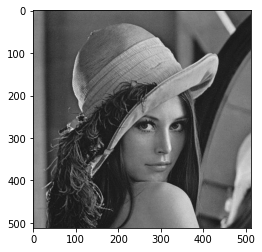

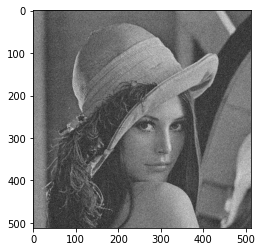

sigma = 20
PSNR = 22.096164134473412


In [ ]:
url = 'https://dpt-info.u-strasbg.fr/~cronse/TIDOC/FILTER/lenna/lenna.png'
img = io.imread('lena_512x512.png')[:,:,0]
print(img.shape)
sigma = 20

plt.imshow(img,cmap='gray')
plt.show()
noisy_image = add_noise(img,sigma)
plt.imshow(noisy_image,cmap='gray')
plt.show()

print('sigma = ' + str(sigma))
print('PSNR = ' + str(compute_psnr(img,noisy_image)))

In [ ]:
image = noisy_image
image.shape

(512, 512)

In [ ]:
n = 8
stride = 3
nb_block_max = 16
neigh_size = 39
neigh_stride = stride

In [ ]:
def get_list_blocks(image): 
  liste_blocks = []
  coord = []
  for i in range (0, image.shape[0]-n+1, stride):
    for j in range (0, image.shape[1]-n+1, stride):
      liste_blocks.append(image[i:i+n,j:j+n])
      coord.append((i,j))
  return liste_blocks,coord

def get_neighboors_block(image,coord_bloc,neigh_stride):
  neigh = []
  coords = []
  x0,y0 = coord_bloc
  x0,y0 = np.array([x0,y0]) - np.array([neigh_size//2,neigh_size//2])
  for i in range(0,neigh_size,neigh_stride):
    for j in range(0,neigh_size,neigh_stride):
      if len(image)-n >= x0+i >= 0 and  len(image)-n >= y0+j >= 0:
        bloc = image[x0+i:x0+i+n,y0+j:y0+j+n]
        neigh.append(bloc)
        coords.append([x0+i,y0+j])
  return neigh,coords

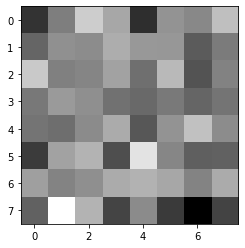

In [ ]:
liste_blocks,coord = get_list_blocks(image)
plt.imshow(liste_blocks[0], cmap = 'gray')


In [ ]:
np.array(liste_blocks).shape

(28561, 8, 8)

In [ ]:
# Grouping
def grouping(liste_blocks, coord_blocks,threshold,wie=False):
  blocks = np.array(liste_blocks)
  list_clust = []
  coordonnées = []
  for i,bloc in enumerate(blocks):
    cluster = [bloc]
    coordonnées_bloc=[coord[i]]
    neighs,neighs_coords = get_neighboors_block(image,coord[i],neigh_stride)
    for j,bloc2 in enumerate(neighs):
      if len(cluster) > nb_block_max :
        continue
      if not wie:
        distance = la.norm(dct2D(bloc)-dct2D(bloc2))**2/(n**2)
      else:
        distance = la.norm(bloc-bloc2)**2/(n**2)
      if 0 < distance < threshold :
          cluster.append(bloc2)
          coordonnées_bloc.append(neighs_coords[j])
    cluster = np.array(cluster)
    list_clust.append(cluster)
    coordonnées.append(coordonnées_bloc)
    if i % 500 == 0:
      print(i,'/',len(blocks)-1)
  print(i,'/',len(blocks)-1)
  return list_clust, coordonnées

In [ ]:
list_clust, coordonnées = grouping(liste_blocks,coord,2500)

0 / 28560
500 / 28560
1000 / 28560
1500 / 28560
2000 / 28560
2500 / 28560
3000 / 28560
3500 / 28560
4000 / 28560
4500 / 28560
5000 / 28560
5500 / 28560
6000 / 28560
6500 / 28560
7000 / 28560
7500 / 28560
8000 / 28560
8500 / 28560
9000 / 28560
9500 / 28560
10000 / 28560
10500 / 28560
11000 / 28560
11500 / 28560
12000 / 28560
12500 / 28560
13000 / 28560
13500 / 28560
14000 / 28560
14500 / 28560
15000 / 28560
15500 / 28560
16000 / 28560
16500 / 28560
17000 / 28560
17500 / 28560
18000 / 28560
18500 / 28560
19000 / 28560
19500 / 28560
20000 / 28560
20500 / 28560
21000 / 28560
21500 / 28560
22000 / 28560
22500 / 28560
23000 / 28560
23500 / 28560
24000 / 28560
24500 / 28560
25000 / 28560
25500 / 28560
26000 / 28560
26500 / 28560
27000 / 28560
27500 / 28560
28000 / 28560
28500 / 28560
28560 / 28560


In [ ]:
clust = np.array(list_clust)
clust[-1].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(17, 8, 8)

In [ ]:
A=0
for k in range(clust.shape[0]):
  A+=clust[k].shape[0]
print('Nombre de blocks total : ', A)
print('Nombre de blocks moyen par groupe : ', int(A/len(liste_blocks)))

Nombre de blocks total :  476844
Nombre de blocks moyen par groupe :  16


In [ ]:
Clusters = clust

In [ ]:
'''
plt.figure(figsize=(10,20))
j = 7
for i in range(0,4) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(Clusters[j][i], cmap = 'gray')
    plt.title('Label:'+str(j))
'''

"\nplt.figure(figsize=(10,20))\nj = 7\nfor i in range(0,4) :\n    plt.subplot(10,5,i+1)\n    plt.axis('off')\n    plt.imshow(Clusters[j][i], cmap = 'gray')\n    plt.title('Label:'+str(j))\n"

In [ ]:
'''
plt.figure(figsize=(10,20))
j = 15
for i in range(0,4) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(Clusters[j][i], cmap = 'gray')
    plt.title('Label:'+str(j))
'''

"\nplt.figure(figsize=(10,20))\nj = 15\nfor i in range(0,4) :\n    plt.subplot(10,5,i+1)\n    plt.axis('off')\n    plt.imshow(Clusters[j][i], cmap = 'gray')\n    plt.title('Label:'+str(j))\n"

In [ ]:
np.array(Clusters[0]).shape

(17, 8, 8)

In [ ]:
coordonnes_clus1 = np.array(coordonnées)

print(coordonnes_clus1[12])

[(0, 36), [2, 20], [2, 23], [2, 26], [2, 29], [2, 32], [2, 35], [2, 38], [2, 41], [2, 44], [2, 47], [2, 50], [2, 53], [5, 20], [5, 23], [5, 26], [5, 29]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
lamb2d = 0
lamb3d = 2.7

def Step1_3DFiltering(lamb3d,sigma,BlockGroup):
    """
    Do collaborative hard-thresholding which includes 3D transform, noise attenuation through 
    hard-thresholding and inverse 3D transform
    
    Return:
        BlockGroup
    """

    for i,block in enumerate(BlockGroup):
      BlockGroup[i] = dct2D(block)

    ThreValue = lamb3d * sigma
    
    nonzero_cnt = 0
    
    for i in range(BlockGroup.shape[1]):
        for j in range(BlockGroup.shape[2]):
            ThirdVector = dct(BlockGroup[:, i, j], norm = 'ortho') # 1D DCT
            ThirdVector[abs(ThirdVector[:]) < ThreValue] = 0.
            nonzero_cnt += np.nonzero(ThirdVector)[0].size
            BlockGroup[:, i, j] = list(idct(ThirdVector, norm = 'ortho'))

    for i,block in enumerate(BlockGroup):
      BlockGroup[i] = idct2D(block)
    
    return BlockGroup, nonzero_cnt

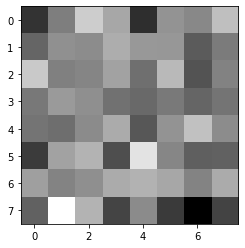

In [ ]:
exp = Step1_3DFiltering(lamb3d,sigma,np.array(Clusters[0]))[0]
plt.imshow(Clusters[0][0], cmap = 'gray')

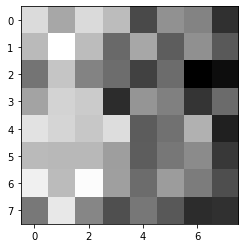

In [ ]:
plt.imshow(exp[0], cmap = 'gray')

In [ ]:
Kaiser_Window_beta = 2.0
Window = np.matrix(np.kaiser(n, Kaiser_Window_beta))
InitKaiser = np.array(Window.T * Window)
print(InitKaiser.shape)

(8, 8)


In [ ]:
def Weights(lamb3d, sigma, clusters):

  clusters_3DFiltered = []
  weights = []

  for group in clusters:
    group_filtered, nonzero_cnt = Step1_3DFiltering(lamb3d, sigma, np.array(group))
    if nonzero_cnt >= 1:
      weight = 1/(sigma**2 * nonzero_cnt)
    else:
      weight = 1.0

    clusters_3DFiltered.append(group_filtered)
    weights.append(weight)

  return weights, clusters_3DFiltered

In [ ]:
weights,filtered_groups = Weights(lamb3d=lamb3d,sigma=sigma,clusters=Clusters)
print(len(weights))

28561


In [ ]:
def Aggregation(weights, Y, coor_Y):
    """generate the reconstruction of the image, based on the global estimate Y

    Args:
        weights (Array): Contains the weights of the reference blocks
        Y (list of Array): Contains all the groups
        coor_Y ([type]): Same size as Y but contains coordinates of the blocks

    Returns:
        Array(256,256): Image after reconstruction
    """
    num = 0
    den = 0
    for i in range(len(Y)) :
        if i % 500 == 0:
          print(i,'/',len(Y)-1)
        for j,block in enumerate(Y[i]):
            weights[i] = weights[i]*InitKaiser
            weighted_block = weights[i]*block
            num += padded_block(weighted_block,coor_Y[i][j])
            den += padded_block(weights[i],coor_Y[i][j])

    res = num/den
    return np.nan_to_num(res)
        
def padded_block(block,coord):
    res= np.zeros((512,512))
    for i in range(len(block)):
        for j in range(len(block)):
            res[i + coord[0]][j+coord[1]] = block[i,j]
    return res

In [ ]:
Y_basic = Aggregation(weights,filtered_groups,coordonnes_clus1)


0 / 28560
500 / 28560
1000 / 28560
1500 / 28560
2000 / 28560
2500 / 28560
3000 / 28560
3500 / 28560
4000 / 28560
4500 / 28560
5000 / 28560
5500 / 28560
6000 / 28560
6500 / 28560
7000 / 28560
7500 / 28560
8000 / 28560
8500 / 28560
9000 / 28560
9500 / 28560
10000 / 28560
10500 / 28560
11000 / 28560
11500 / 28560
12000 / 28560
12500 / 28560
13000 / 28560
13500 / 28560
14000 / 28560
14500 / 28560
15000 / 28560
15500 / 28560
16000 / 28560
16500 / 28560
17000 / 28560
17500 / 28560
18000 / 28560
18500 / 28560
19000 / 28560
19500 / 28560
20000 / 28560
20500 / 28560
21000 / 28560
21500 / 28560
22000 / 28560
22500 / 28560
23000 / 28560
23500 / 28560
24000 / 28560
24500 / 28560
25000 / 28560
25500 / 28560
26000 / 28560
26500 / 28560
27000 / 28560
27500 / 28560
28000 / 28560
28500 / 28560


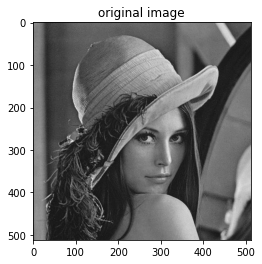

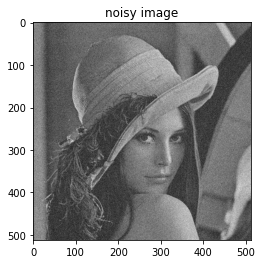

PSNR noisy image : 22.09662301535267


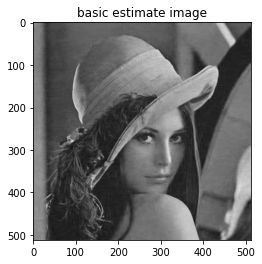

PSNR estimate image after step 1 :  29.67795898030195


In [ ]:
plt.imshow(img,cmap='gray')
plt.title('original image')
plt.show()
plt.imshow(image,cmap='gray')
plt.title('noisy image')
plt.show()
print("PSNR noisy image :",compute_psnr(img[:-10,:-10],image[:-10,:-10]))
plt.imshow(Y_basic,cmap='gray')
plt.title('basic estimate image')
plt.show()
print("PSNR estimate image after step 1 : ",compute_psnr(img[:-10,:-10],Y_basic[:-10,:-10]))

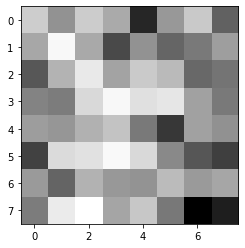

In [ ]:
liste_blocks2,coord2 = get_list_blocks(Y_basic)
plt.imshow(liste_blocks2[0], cmap = 'gray')

In [ ]:
cluster_y_basic, coordonnées2 = grouping(liste_blocks2, coord2, 400,wie=True)
clust2=np.array(cluster_y_basic)

0 / 28560
500 / 28560
1000 / 28560
1500 / 28560
2000 / 28560
2500 / 28560
3000 / 28560
3500 / 28560
4000 / 28560
4500 / 28560
5000 / 28560
5500 / 28560
6000 / 28560
6500 / 28560
7000 / 28560
7500 / 28560
8000 / 28560
8500 / 28560
9000 / 28560
9500 / 28560
10000 / 28560
10500 / 28560
11000 / 28560
11500 / 28560
12000 / 28560
12500 / 28560
13000 / 28560
13500 / 28560
14000 / 28560
14500 / 28560
15000 / 28560
15500 / 28560
16000 / 28560
16500 / 28560
17000 / 28560
17500 / 28560
18000 / 28560
18500 / 28560
19000 / 28560
19500 / 28560
20000 / 28560
20500 / 28560
21000 / 28560
21500 / 28560
22000 / 28560
22500 / 28560
23000 / 28560
23500 / 28560
24000 / 28560
24500 / 28560
25000 / 28560
25500 / 28560
26000 / 28560
26500 / 28560
27000 / 28560
27500 / 28560
28000 / 28560
28500 / 28560
28560 / 28560


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
A=0
for k in range(len(cluster_y_basic)):
  A+=cluster_y_basic[k].shape[0]
print('Nombre de blocks total : ', A)
print('Nombre de blocks moyen par groupe : ', int(A/len(cluster_y_basic)))

Nombre de blocks total :  264574
Nombre de blocks moyen par groupe :  9


In [ ]:
cluster_z = []
for coords in coordonnées2:
  groupk=[]
  for coord_block in coords:
    (x,y) = coord_block
    groupk.append(image[x:x+n,y:y+n])
  cluster_z.append(np.array(groupk))

print(cluster_z[-1].shape)

(6, 8, 8)


In [ ]:
def Step2_3DFiltering(BlockGroup_basic, BlockGroup_noisy,sigma):

    """
    Do collaborative Wiener filtering and here we choose 2D DCT + 1D DCT as the 3D transform which 
    is the same with the 3D transform in hard-thresholding filtering
    Note that the Wiener weight is set accroding to the BM3D analysis paper rather than the original 
    one
    Return:
       BlockGroup_noisy & WienerWeight
    """
    BlockGroup_basic = np.array(BlockGroup_basic)
    BlockGroup_noisy = np.array(BlockGroup_noisy)

    for i,block in enumerate(BlockGroup_basic):
      BlockGroup_basic[i] = dct2D(block)

    for i,block in enumerate(BlockGroup_noisy):
      BlockGroup_noisy[i] = dct2D(block)

    Weight = 0
    coef = 1.0 / BlockGroup_noisy.shape[0]
    for i in range(BlockGroup_noisy.shape[1]):
        for j in range(BlockGroup_noisy.shape[2]):
            Vec_basic = dct(BlockGroup_basic[:, i, j], norm = 'ortho')
            Vec_noisy = dct(BlockGroup_noisy[:, i, j], norm = 'ortho')
            Vec_value = Vec_basic**2 * coef
            Vec_value /= (Vec_value + sigma**2) # pixel weight
            Vec_noisy *= Vec_value
            Weight += np.sum(Vec_value)
            BlockGroup_noisy[:, i, j] = list(idct(Vec_noisy, norm = 'ortho'))
    if Weight > 0:
        WienerWeight = 1./(sigma**2 * Weight**2)
    else:
        WienerWeight = 1.0      

    for i,block in enumerate(BlockGroup_noisy):
      BlockGroup_noisy[i] = idct2D(block)

    return BlockGroup_noisy, WienerWeight

In [ ]:
def Step2_Weights(ListGroup_basic, ListGroup_noisy, sigma):

  clusters_3DFiltered = []
  weights = []

  for i,group in enumerate(ListGroup_basic):
    BlockGroup_noisy, WienerWeight = Step2_3DFiltering(group, ListGroup_noisy[i], sigma)

    clusters_3DFiltered.append(BlockGroup_noisy)
    weights.append(WienerWeight)

  return weights, clusters_3DFiltered

In [ ]:
ListWeight, BlockGroup_noisy = Step2_Weights(cluster_y_basic, cluster_z, sigma)

In [ ]:
Y_final = Aggregation(ListWeight, BlockGroup_noisy, coordonnées2)

0 / 28560
500 / 28560
1000 / 28560
1500 / 28560
2000 / 28560
2500 / 28560
3000 / 28560
3500 / 28560
4000 / 28560
4500 / 28560
5000 / 28560
5500 / 28560
6000 / 28560
6500 / 28560
7000 / 28560
7500 / 28560
8000 / 28560
8500 / 28560
9000 / 28560
9500 / 28560
10000 / 28560
10500 / 28560
11000 / 28560
11500 / 28560
12000 / 28560
12500 / 28560
13000 / 28560
13500 / 28560
14000 / 28560
14500 / 28560
15000 / 28560
15500 / 28560
16000 / 28560
16500 / 28560
17000 / 28560
17500 / 28560
18000 / 28560
18500 / 28560
19000 / 28560
19500 / 28560
20000 / 28560
20500 / 28560
21000 / 28560
21500 / 28560
22000 / 28560
22500 / 28560
23000 / 28560
23500 / 28560
24000 / 28560
24500 / 28560
25000 / 28560
25500 / 28560
26000 / 28560
26500 / 28560
27000 / 28560
27500 / 28560
28000 / 28560
28500 / 28560


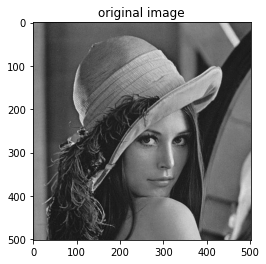

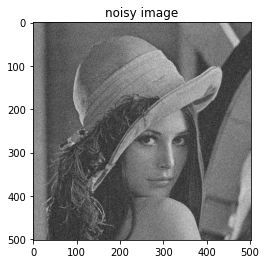

PSNR noisy image : 22.09662301535267


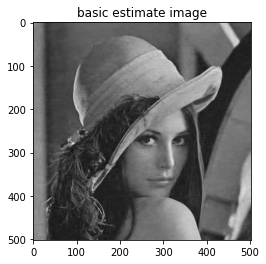

PSNR estimate image after step 1 :  29.67795898030195


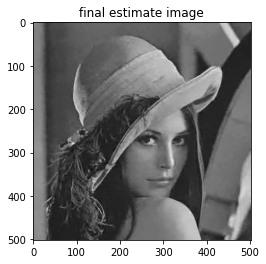

PSNR estimate image after step 2 :  30.646892773094354


In [ ]:
img = img[:-10,:-10]
image = image[:-10,:-10]
Y_basic = Y_basic[:-10,:-10]
Y_final = Y_final[:-10,:-10]

plt.imshow(img,cmap='gray')
plt.title('original image')
plt.show()
plt.imshow(image,cmap='gray')
plt.title('noisy image')
plt.show()
print("PSNR noisy image :",compute_psnr(img,image))
plt.imshow(Y_basic,cmap='gray')
plt.title('basic estimate image')
plt.show()
print("PSNR estimate image after step 1 : ",compute_psnr(img,Y_basic))
plt.imshow(Y_final,cmap='gray')
plt.title('final estimate image')
plt.show()
print("PSNR estimate image after step 2 : ",compute_psnr(img,Y_final))